In [1]:
import torch
import pandas as pd
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("datasets/spam.csv", encoding='ISO-8859-1')
df.head(3)

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [3]:
labels = df["class"] == "spam"
labels = labels.astype("int")
print(labels)

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: class, Length: 5572, dtype: int64


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
cv = TfidfVectorizer(max_features=2000)
X = cv.fit_transform(df['text'])
X = X.todense()
print(X.shape)

(5572, 2000)


In [6]:
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor([labels], dtype=torch.float32).reshape(-1, 1)
print(X.shape, y.shape)

torch.Size([5572, 2000]) torch.Size([5572, 1])


In [8]:
print(len(X[0]))

2000


In [9]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state=42, shuffle=True)

In [10]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

torch.Size([4179, 2000]) torch.Size([1393, 2000]) torch.Size([4179, 1]) torch.Size([1393, 1])


In [11]:
model = nn.Linear(2000, 1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [12]:
losses = []
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    outputs = model(train_x)
    loss = loss_fn(outputs, train_y)
    if i % 100 == 0:
        losses.append(loss.item())
    loss.backward()
    optimizer.step()

100%|███████████████| 10000/10000 [00:19<00:00, 503.74it/s]


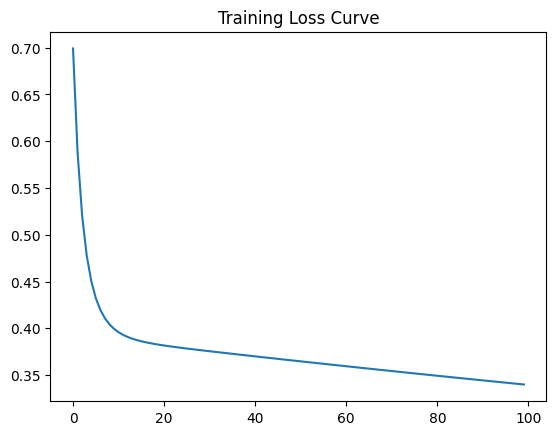

In [13]:
plt.title("Training Loss Curve")
plt.plot(losses)
plt.show()

In [24]:
model.eval()
with torch.no_grad():
    y_pred = nn.functional.sigmoid(model(test_x)) > 0.2
    y_pred = y_pred.reshape(-1, 1).type(torch.float32) 
    # Out of all samples, how many predictions match the true labels.
    accuracy = (y_pred == test_y).type(torch.float32).mean()
    # The proportion of actual positive cases that are correctly identified as positive.
    sensitivity = (y_pred[test_y == 1] == test_y[test_y == 1]).type(torch.float32).mean()
    # The proportion of actual negative cases that are correctly identified as negative.
    specificity = (y_pred[test_y == 0] == test_y[test_y == 0]).type(torch.float32).mean()
    # The proportion of predicted positive cases that are actually positive.
    precision = (y_pred[y_pred == 1] == test_y[y_pred == 1]).type(torch.float32).mean()
    print(f"Accuracy: {accuracy.item()}, Sensitivity: {sensitivity.item()}, Specificity: {specificity.item()}, Precision: {precision.item()}")

Accuracy: 0.9030868411064148, Sensitivity: 0.2931937277317047, Specificity: 1.0, Precision: 1.0


In [25]:
text = "Movie sucks and plot is so stupid"
x = cv.transform([text])
x = torch.tensor(x.todense(), dtype=torch.float32)
y = nn.functional.sigmoid(model(x))
result = "Spam" if y[0].item() > 0.5 else "Ham"
print(f"{result} : {y[0].item()}")

Ham : 0.1230902448296547


In [26]:
text = "That's amazing!! how's it going"
x = cv.transform([text])
x = torch.tensor(x.todense(), dtype=torch.float32)
y = nn.functional.sigmoid(model(x))
result = "Spam" if y[0].item() > 0.5 else "Ham"
print(f"{result} : {y[0].item()}")

Ham : 0.11008002609014511
